In [1]:
import os.path
import numpy as np
import tensorflow as tf
import helper
from pprint import pprint
import warnings
from distutils.version import LooseVersion
import project_tests as tests
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
# # Check TensorFlow Version
# assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
# print('TensorFlow Version: {}'.format(tf.__version__))

In [4]:
# # Check for a GPU
# if not tf.test.gpu_device_name():
#     warnings.warn('No GPU found. Please use a GPU to train your neural network.')
# else:
#     print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))


In [5]:
def load_vgg(sess, vgg_path):
    """
    Load Pretrained VGG Model into TensorFlow.
    :param sess: TensorFlow Session
    :param vgg_path: Path to vgg folder, containing "variables/" and "saved_model.pb"
    :return: Tuple of Tensors from VGG model (image_input, keep_prob, layer3_out, layer4_out, layer7_out)
    """
    vgg_tag = 'vgg16' 
    
    tf.saved_model.loader.load(sess, [vgg_tag], vgg_path)
    
#     pprint(sess.graph.get_operations())
    
    vgg_input_tensor = sess.graph.get_tensor_by_name('image_input:0')
    vgg_keep_prob_tensor = sess.graph.get_tensor_by_name('keep_prob:0')
    vgg_layer3_out_tensor = sess.graph.get_tensor_by_name('layer3_out:0')
    vgg_layer4_out_tensor = sess.graph.get_tensor_by_name('layer4_out:0')
    vgg_layer7_out_tensor = sess.graph.get_tensor_by_name('layer7_out:0')
    
    return vgg_input_tensor, vgg_keep_prob_tensor, vgg_layer3_out_tensor, \
            vgg_layer4_out_tensor, vgg_layer7_out_tensor
# tests.test_load_vgg(load_vgg, tf)

In [6]:
def layers(vgg_layer3_out, vgg_layer4_out, vgg_layer7_out, num_classes):
    """
    Create the layers for a fully convolutional network.  Build skip-layers using the vgg layers.
    :param vgg_layer7_out: TF Tensor for VGG Layer 3 output
    :param vgg_layer4_out: TF Tensor for VGG Layer 4 output
    :param vgg_layer3_out: TF Tensor for VGG Layer 7 output
    :param num_classes: Number of classes to classify
    :return: The Tensor for the last layer of output
    """
    with tf.variable_scope('decoder_layer_0'):
        # 1x1 conv - resample for our class number in depth
        resampled_vgg_7 = tf.layers.conv2d(inputs=vgg_layer7_out, 
                                            filters=num_classes,
                                            kernel_size=(1, 1),
                                            padding='same',
                                            name='resampled_vgg_7')
        
        
    with tf.variable_scope('decoder_layer_1'):
        # trans-conv - upsample with fractionally strided conv
        upsampled_vgg_7_to_4 = tf.layers.conv2d_transpose(inputs=resampled_vgg_7,
                                                          filters=num_classes,
                                                          kernel_size=(4, 4),
                                                          strides=(2,2),
                                                          padding='same',
                                                          name='upsampled_vgg_7')
        
        # 1x1 conv - resample for our class number in depth
        resampled_vgg_4 = tf.layers.conv2d(inputs=vgg_layer4_out, 
                                            filters=num_classes,
                                            kernel_size=(1, 1),
                                            padding='same',
                                            name='resampled_vgg_4')
        
        # skip connection - combine with mid-granularity encoding layer
        decoder_layer_1 = tf.add(upsampled_vgg_7_to_4, resampled_vgg_4, name='skip_connect_layer_0')
        

    with tf.variable_scope('decoder_layer_2'):
        # trans-conv - upsample with fractionally strided conv
        upsampled_vgg_4_to_3 = tf.layers.conv2d_transpose(inputs=decoder_layer_1,
                                                          filters=num_classes,
                                                          kernel_size=(4, 4),
                                                          strides=(2,2),
                                                          padding='same',
                                                          name='upsampled_vgg_4')
        
        # 1x1 conv - resample for our class number in depth
        resampled_vgg_3 = tf.layers.conv2d(inputs=vgg_layer3_out, 
                                            filters=num_classes,
                                            kernel_size=(1, 1),
                                            padding='same',
                                            name='resampled_vgg_3')
        
        # skip connection - combine with mid-granularity encoding layer
        decoder_layer_2 = tf.add(upsampled_vgg_4_to_3, resampled_vgg_3, name='skip_connect_layer_1')
        

    DOUBLINGS_REMAINING = 4
    with tf.variable_scope('decoder_layer_3'):
        # FINAL UPSAMPLING TO ORIGINAL DIMENSIONS. WHAT IS THE IMPACT OF DOING A 
        #   MORE AGGRESSIVE UPSAMPLING VS. A SEQUENCE OF SMALLER ONES?
        # *** TODO: CREATE FCN LAYER GENERATOR (AT LEAST FOR NON-SKIP CONNECTION 
        #       LAYERS BASED ON TESTED TENSOR SHAPES FOUND IN RUN() BELOW!***)
        # Combinatorially uses different VGG, or whatever, layers to create skip
        #   layers and evaluates the model?
        upsampled_vgg_3_to_output = tf.layers.conv2d_transpose(inputs=decoder_layer_2,
                                                          filters=num_classes,
                                                          kernel_size=(4*DOUBLINGS_REMAINING, 
                                                                       4*DOUBLINGS_REMAINING),
                                                          strides=(2*DOUBLINGS_REMAINING,
                                                                   2*DOUBLINGS_REMAINING),
                                                          padding='same',
                                                          name='upsampled_final_output')        
    return upsampled_vgg_3_to_output
# tests.test_layers(layers)

In [7]:
def optimize(nn_last_layer, correct_label, learning_rate, num_classes):
    """
    Build the TensorFLow loss and optimizer operations.
    :param nn_last_layer: TF Tensor of the last layer in the neural network
    :param correct_label: TF Placeholder for the correct label image
    :param learning_rate: TF Placeholder for the learning rate
    :param num_classes: Number of classes to classify
    :return: Tuple of (logits, train_op, cross_entropy_loss)
    """
    # to int64?
    logits = tf.reshape(nn_last_layer, (-1, num_classes))
    reshaped_label = tf.reshape(correct_label, (-1, num_classes))
    
    xentropy = tf.nn.softmax_cross_entropy_with_logits(labels=reshaped_label, logits=logits)
    mean_xentropy_loss = tf.reduce_mean(xentropy, name='mean_xentropy_loss')
    
    tf.summary.scalar('mean_xentropy_loss', mean_xentropy_loss)
    
    optimizer = tf.train.AdamOptimizer(learning_rate)
#     global_step = tf.Variable(0, name='global_step', trainable=False)
    train_op = optimizer.minimize(mean_xentropy_loss)#, global_step=global_step)
    return logits, train_op, mean_xentropy_loss 
# tests.test_optimize(optimize)

In [8]:
def train_nn(sess, epochs, batch_size, get_batches_fn, train_op, cross_entropy_loss, input_image,
             correct_label, keep_prob, learning_rate):
    """
    Train neural network and print out the loss during training.
    :param sess: TF Session
    :param epochs: Number of epochs
    :param batch_size: Batch size
    :param get_batches_fn: Function to get batches of training data.  Call using get_batches_fn(batch_size)
    :param train_op: TF Operation to train the neural network
    :param cross_entropy_loss: TF Tensor for the amount of loss
    :param input_image: TF Placeholder for input images
    :param correct_label: TF Placeholder for label images
    :param keep_prob: TF Placeholder for dropout keep probability
    :param learning_rate: TF Placeholder for learning rate 
    """
    # TODO: Implement function
    init = tf.global_variables_initializer() # necessary?
    sess.run(init)
    
    card_X = 0
    sum_loss = 0.

    for epoch in range(epochs):
        for X_batch, y_batch in get_batches_fn(batch_size):
            card_X += len(X_batch)
#             print(X_batch.shape)
#             print(type(X_batch))
            feed_dict = {
                input_image: np.float32(X_batch),
                correct_label: y_batch,
                keep_prob: 0.8
            }
            _, loss_val = sess.run([train_op, cross_entropy_loss], feed_dict=feed_dict)
            sum_loss += loss_val
        mean_loss = sum_loss / card_X
        print('mean_loss: {}'.format(mean_loss))
# tests.test_train_nn(train_nn)

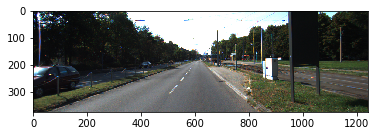

In [9]:
img = plt.imread('./data/data_road/testing/image_2/um_000000.png')
plt.imshow(img)

In [10]:
np.expand_dims(img, 0).shape

(1, 375, 1242, 3)

In [ ]:
def run():
    num_classes = 2
    image_shape = (160, 576)
    data_dir = './data'
    runs_dir = './runs'
    tests.test_for_kitti_dataset(data_dir)
    epochs = 5
    batch_size = 20
    # Download pretrained vgg model
#     helper.maybe_download_pretrained_vgg(data_dir)

    # OPTIONAL: Train and Inference on the cityscapes dataset instead of the Kitti dataset.
    # You'll need a GPU with at least 10 teraFLOPS to train on.
    #  https://www.cityscapes-dataset.com/
    tf.reset_default_graph()
    sample = plt.imread('./data/data_road/testing/image_2/um_000000.png')
    with tf.Session() as sess:
        learning_rate = tf.constant(0.0001)
        keep_prob = tf.constant(0.8, tf.float32)
        # Path to vgg model
        vgg_path = os.path.join(data_dir, 'vgg')
        vgg_tag = 'vgg16' 

        # HOF that creates function to get batches
        get_batches_fn = helper.gen_batch_function(os.path.join(data_dir, 'data_road/training'), image_shape)

        vgg_input_tensor, vgg_keep_prob_tensor, vgg_layer3_out_tensor, \
            vgg_layer4_out_tensor, vgg_layer7_out_tensor = load_vgg(sess, vgg_path)
        
        # TODO: Build NN using load_vgg, layers, and optimize function
        fcn_output = layers(vgg_layer3_out_tensor, vgg_layer4_out_tensor, vgg_layer7_out_tensor, num_classes)
        
        input_image = tf.placeholder(tf.int32, [None, image_shape[0], image_shape[1], 3])
        correct_label = tf.placeholder(tf.float32, [None, image_shape[0], image_shape[1], num_classes])
        
        logits, train_op, mean_xentropy_loss = optimize(fcn_output, correct_label, learning_rate, num_classes)
        
        # TODO: Train NN using the train_nn function
        train_nn(sess, epochs, batch_size, get_batches_fn, train_op, mean_xentropy_loss, vgg_input_tensor,
             correct_label, vgg_keep_prob_tensor, learning_rate)



if __name__ == '__main__':
    run()


Tests Passed
INFO:tensorflow:Restoring parameters from b'./data/vgg/variables/variables'


In [ ]:
        # OPTIONAL: Augment Images for better results
        #  https://datascience.stackexchange.com/questions/5224/how-to-prepare-augment-images-for-neural-network
        
        # TODO: Save inference data using helper.save_inference_samples
        #  helper.save_inference_samples(runs_dir, data_dir, sess, image_shape, logits, keep_prob, input_image)
        
        # EVALUATE TEST ACCURACY
#         card_X = 0
#         total_accuracy = 0

#         correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
#         accuracy_op = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        
#         for epoch in range(epochs):
#             for X_batch, y_batch in get_batches_fn(batch_size):
#                 card_X += len(X_batch)
#                 feed_dict = {
#                     input_image: X_batch,
#                     correct_label: y_batch,
#                     keep_prob: 1.0
#                 }
#                 accuracy = sess.run(accuracy_op, feed_dict)
#                 total_accuracy += (accuracy * len(batch_x))
#         print("Accuracy on test batch: {}".format(total_accuracy / card_X))
            
                
#                 validation_accuracy = evaluate(X_batch, y_batch)

        # OPTIONAL: Apply the trained model to a video

In [ ]:
#         tf.saved_model.loader.load(sess, [vgg_tag], './data/vgg')#vgg_path)
#         sess.graph.eval(something)
        #     'dropout_1/Shape'
#         test_tensor = sess.graph.get_tensor_by_name('layer7_out:0')
#         print(test_tensor)
#         print(tf.shape(test_tensor))
#         print(sess.graph.get_tensor_by_name('dropout_1/Shape:0'))
#         print(sess.graph.get_tensor_by_name('image_input:0'))

#         test_tensor.get_shape()
#         pprint(sess.graph.get_operations())
#         print(sess.run('pool3', feed_dict))
        #NOTA BENE: LAYERS ARE SELECTED TO BE 50% RES FROM ONE TO NEXT
        # BUT COULD DO BELOW TO FIND OUT AND AUTOGEN UPSAMPLING RATIOS
#         pprint(sess.run('image_input:0', feed_dict).shape)
#         pprint(sess.run('layer3_out:0', feed_dict).shape)
#         pprint(sess.run('layer4_out:0', feed_dict).shape)
#         pprint(sess.run('layer7_out:0', feed_dict).shape)

In [ ]:
    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
#     accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
#     saver = tf.train.Saver()
saver.save(sess, 'lenet')
    print("Model saved")

# FINALLY, evaluate the model
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))